## Семинар 3 "Определение ключевых точек лица"

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  21 октября 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [1]:
!pip install pytorch-ignite

In [2]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
# Ignore warnings
import warnings
from torch import nn
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss




Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


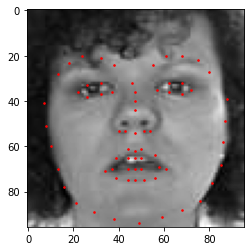

In [3]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.values[n, 0]
landmarks = landmarks_frame.values[n, 1:].astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [4]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [40]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)
        image, landmarks = sample
        
        sample = image.expand(3,96, 96) , landmarks
        return sample

In [41]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [42]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())

In [43]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

Возьмем сверточную сеть которая висит на сайте torch в качестве образца 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(7744, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 136)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(x.size()[0], 68,2)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
torch.cuda.is_available()

False

In [44]:
network = model
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="out_logs")

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 100

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [45]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
   

In [184]:
train_dataloader

In [185]:
trainer.run(train_dataloader, max_epochs=max_epochs)

Training/Validation Results - Epoch: 100  Avg MSE: 17.62 / 18.70 Avg MAE: 2.98 / 3.0636

State:
	iteration: 9800
	epoch: 100
	epoch_length: 98
	max_epochs: 100
	output: 12.696693420410156
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

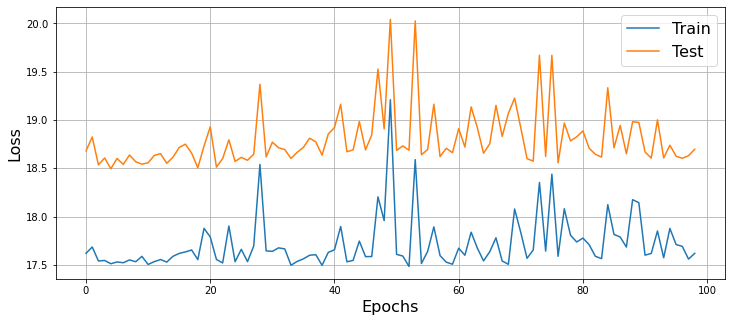

In [186]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

Я запускал сеть несколько раз на 10 эпох 30 и 100 - вообще самый удачный результат был получен при 30 эпохах MSE(train) = около 14 mse(test) = mse(train)+ 2 = 16 

Нарастим глубину сети и так же сделаем более планвое уменьшение папарметров в олносвязном слое 

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2048, 1024)  # 6*6 from image dimension
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 136)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(x.size()[0], 68,2)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [25]:
trainer.run(train_dataloader, max_epochs=max_epochs)

Training/Validation Results - Epoch: 30  Avg MSE: 9.59 / 11.54 Avg MAE: 2.27 / 2.461

State:
	iteration: 2940
	epoch: 30
	epoch_length: 98
	max_epochs: 30
	output: 8.850920677185059
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

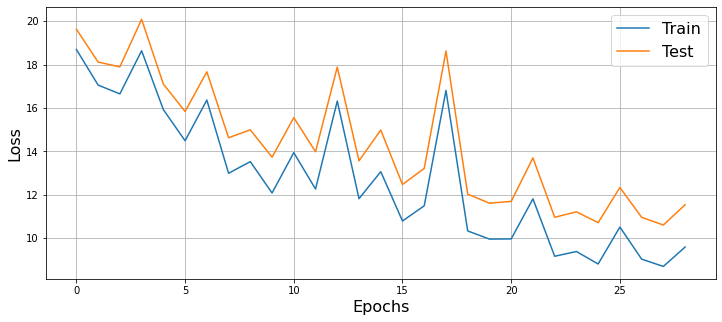

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

НАращивание глубины дало значитительное улучшение результата
Теперь нарастим глубину еще сильнее и перед каждым макспулом будем делать 2 светки а не 1


In [72]:
##### YOUR CODE HERE #####
image_size = 96
channels = 1
class Net(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, (3,3), padding=(1,1)), nn.ReLU(),
                                        nn.Conv2d(8, 16, (3,3), padding=(1,1)), nn.ReLU(),
                                        nn.Conv2d(16, 32, (3,3), padding=(1,1)),nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(32, 64, (3,3), padding=(1,1)),nn.ReLU(),
                                        nn.Conv2d(64, 128, (3,3), padding=(1,1)),nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(128, 256, (3,3), padding=(1,1)),nn.ReLU(),
                                        nn.Conv2d(256, 512, (3,3), padding=(1,1)),nn.ReLU(),
                                        nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(73728, 1000),nn.ReLU(),nn.Linear(1000,136))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.linear_layers(x)
        x = x.view(x.size()[0], 68,2)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [75]:
trainer.run(train_dataloader, max_epochs=max_epochs) # обучил эту архитектеру на компе у друга она будет рассмотрена в 
# другом файле который я прикреплю к письму (на моем бедном ноуте с вирт машиной без доступа к gpu я ждал день комп
 # на компе можно было жарить еду но прошло лолько 17 эпох)

Training/Validation Results - Epoch: 20  Avg MSE: 14.19 / 15.43 Avg MAE: 2.65 / 2.74896

Engine run is terminating due to exception: .


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [9]:
from torchvision import models

In [28]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.require_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 68 * 2)
model.fc1 = torch.nn.Linear(68 * 2, 68 * 2)

In [29]:
train_dataloader, test_dataloader = get_data_loaders()

device = torch.device("cpu")# if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)#, weight_decay=0.001)

In [74]:
train_dataset.__getitem__(0)[1].size()

torch.Size([68, 2])

используем трансфер лернинг его запуск буду производить на компе друга и скину отельный файл
предыдущая сеть которая тоже запускалась у друга не дала падения в mse был получен скор 17 на тесте (я вам в чатик кидал фотку графика))

In [77]:
model.eval()

batch_size = 32

train_loss_history = []
test_loss_history  = []

for epoch in range(60):
  
    model.train()
    losses = []

    for i, (X, y) in enumerate(train_dataloader):
       
        X = X.to(device)
        y = y.to(device)
        model.zero_grad()
        y_pred = model.forward(X)
        train_loss = loss(y_pred.view(-1, 68, 2), y)
        losses.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
  
        print("\rtrain mse: %.4f" % losses[-1], '\t\tepoch:', epoch+1, '\t\t(step: %i)' % i, end='')
    
    train_loss_history.append(np.mean(losses))
    model.eval()
    
    print("\rtrain mse: %.4f" % train_loss_history[-1], '\t\tepoch:', epoch+1)




    losses = []
    for i, (X, y) in enumerate(test_dataloader):


        X = X.to(device)
        y = y.to(device)
      
        y_pred = model.forward(X)
        test_loss = loss(y_pred.view(-1, 68, 2), y)
        losses.append(test_loss.item())
      
        print("\rtest mse: %.4f" % losses[-1], '\t\tepoch:', epoch+1, '\t\t(step: %i)' % i, end='')
    
    test_loss_history.append(np.mean(losses))
    print("\rtest mse: %.4f" % test_loss_history[-1], '\t\tepoch:', epoch+1)
    print()

train mse: 17.4390 		epoch: 1 		(step: 67)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,7))

ax.plot(train_loss_history[2:], label='train')
ax.plot(test_loss_history[2:],  label='test')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('MSE loss')
ax.legend()
ax.grid()

In [179]:
_, test_dataloader = get_data_loaders(val_batch_size=64)

(1, 1, 96, 96)


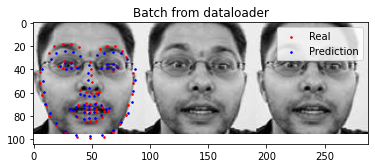

In [148]:
_, test_dataloader = get_data_loaders(val_batch_size=64)
_, test_datal
oader = get_data_loaders(val_batch_size=1)

images_batch = next(iter(test_dataloader))
x, y = images_batch
y_pred = network(x)
y_pred = y_pred.data.numpy()
show_landmarks_batch(images_batch, y_pred)

In [15]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [16]:
writer = SummaryWriter("out_logs/exp2")

In [17]:
for x,y in train_dataloader:
    break

In [18]:
writer.add_graph(network, x)
writer.flush()

In [161]:
# Будем использовать первый слой сети в качестве feature extractor
# с помощью writer.add_embedding визуализируем полученные признаки
# резульат появится во вкладке PROJECTOR
_, test_dataloader = get_data_loaders(val_batch_size=20)

images_batch = next(iter(test_dataloader))




embedder = list(network.modules())[1]

features = embedder(images_batch[0].view(images_batch[0].shape[0], -1))
writer.add_embedding(features,global_step=2)
writer.flush()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 6 1 3 3, but got 2-dimensional input of size [20, 9216] instead

# Links

[Официальная страница ignite](https://pytorch.org/ignite/index.html)

[Официальная страница PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning)


